In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append('../python_scripts/')
import correlations
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

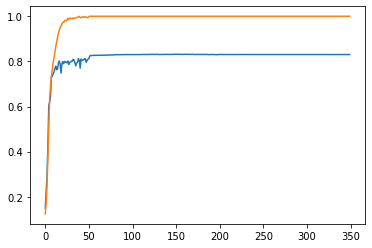

In [15]:
plt.plot(train_0['val_accuracy'])
plt.plot(train_0['accuracy'])loss

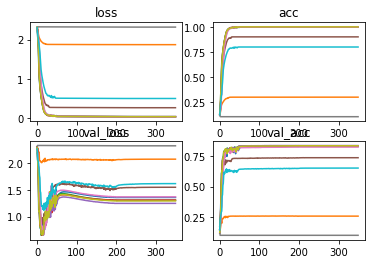

In [17]:
f, axarr = plt.subplots(2,2)
axarr[0,0].set_title('loss')
axarr[0,1].set_title('acc')
axarr[1,0].set_title('val_loss')
axarr[1,1].set_title('val_acc')

for i in range(10):
    train = pickle.load(open('../tests/gpu_variance/with_hash/trainHistoryDict_'+str(i), 'rb'))
    axarr[0,0].plot(train['loss'])
    axarr[0,1].plot(train['accuracy'])
    axarr[1,0].plot(train['val_loss'])
    axarr[1,1].plot(train['val_accuracy'])
    
plt.show()

In [2]:
x_test = np.load('../data/cifar10_modified/x_test_new.npy')
y_test = np.load('../data/cifar10_modified/y_test_new.npy')

In [13]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
model = load_model('../outputs/models/primary/Version_4/all_cnn_c_instance_0.h5')
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
10000/10000 [==============================] - 3s 285us/sample - loss: 1.3388 - accuracy: 0.8291
test loss, test acc: [1.3388182153701782, 0.8291]


In [14]:
_, (_, y_test_b) = cifar10.load_data()

In [15]:
y_test_b = to_categorical(y_test_b)

In [18]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [55]:
y_test_b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
'''
RSA: Create an RDM for each activation layer (90 total) and get correlations between pairings of RDMs
'''
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Flatten
from scipy.stats import pearsonr, spearmanr

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

x_predict, y_predict = correlations.make_test_data(whiten=False)
# Function to correlate 2 RDMs
def correlate(RDM_1, RDM_2):
    print('Making correlations...')
    assert len(RDM_1) == len(RDM_2)
    num_unique_entries = 499500 # for 1000x1000
    arr_1 = np.empty((num_unique_entries))
    arr_2 = np.empty((num_unique_entries))
    counter = 0
    # first flatten all the relevant values
    for i in range(len(RDM_1)): #1000
        for j in range(i + 1, len(RDM_1)):
            arr_1[counter] = RDM_1[i, j]
            arr_2[counter] = RDM_2[i, j]
            counter += 1
    # Get Pearson correlation
    return pearsonr(arr_1, arr_2)[0]


num_images = len(x_predict) # 1000
RDM_list = np.empty((90, 1000, 1000)) #layer * instance, images, images
# Loop through network instances
for i in range(10):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('../outputs/models/primary/Version_4/all_cnn_c_instance_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(0, 9):
        print('Layer', str(j))
        out = full_model.layers[j].output
        # Flatten representation if needed
        if len(out.shape) != 2:
            out = Flatten()(out)
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict, transpose for spearman
        print('Getting representation...')
        representations = temp_model.predict(x_predict).T
        print(representations.shape)
        print('Getting RDM...')
        RDM_list[10 * j + i] = spearmanr(representations, representations)[0][:num_images, :num_images]
        
print('Done gathering RDMs, now correlations')
correlations = np.empty((90, 90))
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        correlations[i, j] = correlate(RDM_list[i], RDM_list[j])

np.save('all_cnn_c_version_4_correlations.npy', correlations)
print('Done!')    
    